# W207 Final Project
Erika, Jen Jen, Geoff, Leslie

(In Python 3)

As of 3/35

Outline:

* Data Pre-Processing  
* Simple Feature Selection
* Basline Models
* Possible Approaches
   

# Section 1 Loading and Processing Data

In [1]:
## Import Libraries ##
import json
from pprint import pprint
from pandas import *
from pandas.io.json import json_normalize
from vaderSentiment import vaderSentiment

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import recall_score

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
## Get Data ##

#reference on data: https://www.kaggle.com/c/random-acts-of-pizza/data
# pull in the training and test data
with open('/Users/gstirling/Desktop/W207_Proj/data/train.json', encoding='utf-8') as data_file:
#with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    trainData = json.loads(data_file.read())   
with open('//Users/gstirling/Desktop/W207_Proj/data/test.json', encoding='utf-8') as data_file:
#with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    testData = json.loads(data_file.read())    

# create a dev data set 
devData = trainData[0:1000]
trainData = trainData[1000:]

# show how the data looks in its original format
#pprint("data in json format:")
#pprint(trainData[1])

# create a normalized view
allTData = json_normalize(trainData)
print("\nSize of the normalized Data:", allTData.shape)
print("\nnormalized data columns:", list(allTData))

allDData = json_normalize(devData)



Size of the normalized Data: (3040, 32)

normalized data columns: ['giver_username_if_known', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subreddits_at_request', 'requester_received_pizza', 'requester_subreddits_at_request

# Section 1.1 Text data analysis

In [3]:
## Create subsets of data for analysis ###

# create a flat dataset without the subreddits list
flatData = allTData.drop('requester_subreddits_at_request', 1)
# create a separate dataset with just subreddits, indexed on request id
# we can creata a count vector on the words, run Naive Bayes against it, 
# and add the probabilities to our flat dataset
subredTData = allTData[['request_id','requester_subreddits_at_request']]
subredTData.set_index('request_id', inplace=True)

subredDData= allDData[['request_id','requester_subreddits_at_request']]
subredDData.set_index('request_id', inplace=True)

# our training labels
trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

# what do these look like?
#print(list(flatData))
print(subredTData.shape)
#print(subredTData['requester_subreddits_at_request'][1])

# create a corpus of subreddits to vectorize
trainCorpus = []
for index in range(len(subredTData)):
    trainCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))

devCorpus = []
for index in range(len(subredDData)):
    devCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))
    


(3040, 1)


In [4]:
# combine all text sources into a single corpus
fldTText = allTData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]
fldDText = allDData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]

trainCorpus = []
for index in range(len(subredTData)):
    a = ' '.join(subredTData['requester_subreddits_at_request'][index])
    b = (a, fldTText['request_text'][index], fldTText['request_text_edit_aware'][index],
        fldTText['request_title'][index])
    trainCorpus.append(' '.join(b))

devCorpus = []
for index in range(len(subredDData)):
    a = ' '.join(subredDData['requester_subreddits_at_request'][index])
    b = (a, fldDText['request_text'][index], fldDText['request_text_edit_aware'][index],
         fldDText['request_title'][index])
    devCorpus.append(' '.join(b))

# Print 3 examples  
print (trainCorpus[:3])
labels = trainLabel.astype(int)
labels = list(labels)
print(labels[:3])
print('-'*75)

print ('\n' , devCorpus[:3])
labels_dev = devLabel.astype(int)
labels_dev = list(labels_dev)
print(labels_dev[:3])

["FoodstuffsAllAround IAmA RandomActsOfCookies RandomActsofCards RandomKindness Random_Acts_Of_Pizza comiccon cosplay cosplayers So it's been a while since it's happened, but yeah. Just got dumped by a girl I like... My brother has used up pretty much everything in the freezer. I would really appreciate a pizza right now... So it's been a while since it's happened, but yeah. Just got dumped by a girl I like... My brother has used up pretty much everything in the freezer. I would really appreciate a pizza right now... [Request] Just got dumped, no food in the freezer. Pizza?", "AskReddit Guitar Jazz Music NSFW_GIF Psychonaut RoomPorn StAugustine TwoXChromosomes WTF YouShouldKnow atheism aww bakedart catpictures cats crochet dubstep ents entwives food funny gonewild hiphopheads listentothis meetup offbeat pics realpics self sex tattoos treecomics treemusic trees videos vinyl zombies My boyfriend and I live in Saint Augustine, Florida and have been having a rough time financially the past

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#posts = subredTData

sentences2 = ["Hello, thank you very much", "No, that's an awful idea"]

sentences.extend(sentences2)
sid = SentimentIntensityAnalyzer()
for post in sentences:
    print(post)
    ss = sid.polarity_scores(post)
    for k in sorted(ss):
        print('{0}': {1}, '.format(k, ss[k]), end='')
    print()
    
#for post in subredTData:
#    print(post,
#    sentiment = vaderSentiment(post))
#    print("\n\t" + str(sentiment))

SyntaxError: invalid syntax (<ipython-input-5-d129f5f5fb57>, line 12)

# Section 1.2 User status analysis (votes, flair)

In [6]:
## CREATE SUBSETS FOR USER STATUS ANALYSIS ##

# subsets for upvotes-downvotes and upvotes+downvotes at time of request and retrieval
diffTrequest = allTData['requester_upvotes_minus_downvotes_at_request']
diffDrequest = allDData['requester_upvotes_minus_downvotes_at_request']
diffTretrieval = allTData['requester_upvotes_minus_downvotes_at_retrieval']
diffDretrieval = allDData['requester_upvotes_minus_downvotes_at_retrieval']
totalvotesTrequest = allTData['requester_upvotes_plus_downvotes_at_request']
totalvotesDrequest = allDData['requester_upvotes_plus_downvotes_at_request']
totalvotesTretrieval = allTData['requester_upvotes_plus_downvotes_at_retrieval']
totalvotesDretrieval = allDData['requester_upvotes_plus_downvotes_at_retrieval']

# subsets for flair (training data only)
Tflair = allTData['requester_user_flair'].copy()

In [7]:
from IPython.display import display

## SUMMARY STATISTICS FOR UPVOTES-DOWNVOTES AT REQUEST AND AT RETRIEVAL ##

print("SUMMARY STATISTICS FOR UPVOTES-DOWNVOTES AT REQUEST AND AT RETRIEVAL")
# UPVOTES-DOWNVOTES AT REQUEST ----------------------
print("\nSummary for upvotes-downvotes at request:")
print(round(diffTrequest.describe(),2), end="\n\n")

# UPVOTES-DOWNVOTES AT RETRIEVAL -------------------
print("-"*100)
print("Summary for upvotes-downvotes at retrieval:")
print(round(diffTretrieval.describe(),2), end="\n\n")


SUMMARY STATISTICS FOR UPVOTES-DOWNVOTES AT REQUEST AND AT RETRIEVAL

Summary for upvotes-downvotes at request:
count      3040.00
mean       1134.19
std        3744.32
min        -173.00
25%           3.00
50%         183.50
75%        1166.00
max      155010.00
Name: requester_upvotes_minus_downvotes_at_request, dtype: float64

----------------------------------------------------------------------------------------------------
Summary for upvotes-downvotes at retrieval:
count      3040.00
mean       2713.92
std        6507.20
min        -173.00
25%          23.00
50%         705.50
75%        3301.25
max      223708.00
Name: requester_upvotes_minus_downvotes_at_retrieval, dtype: float64



In [8]:
from IPython.display import display

## CREATING NEW PARAMETER: the change in upvotes-downvotes from time of request to time of retrieval ##

# user status with new parameter for training data
allTData['request_to_retrieval_upvotes_minus_downvotes'] = diffTretrieval - diffTrequest
diffTcombined = allTData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes','requester_received_pizza']].copy()
# rename column headings
diffTcombined.columns = ['Request', 'Retrieval', 'Request-Retrieval', 'Got Pizza']
print("ADDING NEW PARAMETER - REQUEST-RETRIEVAL:  to represent change in counts from upvotes-downvotes from time of request to time of retrieval.")
print("\nSTATUS TRAINING DATA")
display(diffTcombined.head())

# user status with new parameter for training data
allDData['request_to_retrieval_upvotes_minus_downvotes'] = diffDretrieval - diffDrequest
diffDcombined = allDData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes','requester_received_pizza']].copy()
# rename columne headings
diffDcombined.columns = ['Request', 'Retrieval', 'Request-Retrieval', 'Got Pizza']
print("\n")
print("STATUS DEVELOPMENT DATA")
display(diffDcombined.head())

ADDING NEW PARAMETER - REQUEST-RETRIEVAL:  to represent change in counts from upvotes-downvotes from time of request to time of retrieval.

STATUS TRAINING DATA


,Request,Retrieval,Request-Retrieval,Got Pizza
0,87,97,10,False
1,278,664,386,False
2,206,596,390,True
3,3,3,0,False
4,124,5049,4925,True




STATUS DEVELOPMENT DATA


,Request,Retrieval,Request-Retrieval,Got Pizza
0,0,1,1,False
1,34,4258,4224,False
2,0,3,3,False
3,54,59,5,False
4,1121,1225,104,False


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

## SUMMARY STATISTICS FOR UPVOTES-DOWNVOTES AT REQUEST AND AT RETRIEVAL ##

# upvotes-downvotes at request, grouped by pizza success -------------------------
print("\n\nSUMMARY STATISTICS FOR UPVOTES-DOWNVOTES AT REQUEST AND AT RETRIEVAL, GROUPED BY PIZZA SUCCESS")

diffreq_pizzas = allTData[['requester_upvotes_minus_downvotes_at_request','requester_received_pizza']].copy()
diffreq_pizzas.columns = ['Request', 'Got Pizza']
pizza_diff_request = diffreq_pizzas.groupby(['Got Pizza'])
print("\nGroup upvotes-downvotes at request by pizza success:\n")
print(round(pizza_diff_request.describe(), 2))

# upvotes-downvotes at retrieval, grouped by pizza success -------------------------
diffretrieve_pizzas = allTData[['requester_upvotes_minus_downvotes_at_retrieval','requester_received_pizza']].copy()
diffretrieve_pizzas.columns = ['Retrieval', 'Got Pizza']
pizza_diff_retrieval = diffretrieve_pizzas.groupby(['Got Pizza'])
print("\n")
print("-"*100)
print("\nGroup upvotes-downvotes at retrieval by pizza success:\n")
print(round(pizza_diff_retrieval.describe(), 2))




SUMMARY STATISTICS FOR UPVOTES-DOWNVOTES AT REQUEST AND AT RETRIEVAL, GROUPED BY PIZZA SUCCESS

Group upvotes-downvotes at request by pizza success:

                   Request
Got Pizza                 
False     count    2306.00
          mean     1033.28
          std      2530.16
          min      -173.00
          25%         1.00
          50%       138.00
          75%      1048.75
          max     68436.00
True      count     734.00
          mean     1451.22
          std      6153.27
          min       -39.00
          25%        28.25
          50%       312.00
          75%      1524.50
          max    155010.00


----------------------------------------------------------------------------------------------------

Group upvotes-downvotes at retrieval by pizza success:

                 Retrieval
Got Pizza                 
False     count    2306.00
          mean     2363.97
          std      4631.33
          min      -173.00
          25%        11.00
          50%

In [10]:
## USER FLAIR ##
# None = no pizza
#'shroom' = got pizza without 'pay it forward' (PIF)
# PIF' = got pizza and paid forward

flair = allTData[['requester_user_flair','requester_received_pizza']].copy()
flair.columns = ['Flair', 'Got Pizza']
print("\n")
print("Types of Flair and Pizza Success\n")
print(flair.head(10))
pizza_flair = flair.groupby(['Got Pizza'])
print("\n")
print("-"*100)
print("\nGroup flair by pizza success:\n")
print(round(pizza_flair.describe(),2))

# binarize categorical features in FLAIR
bin_flair = flair['Flair'].replace(['None', 'shroom', 'PIF'], [-1, 0, 1])
bin_flair.value_counts()
print("\nOut of 734 pizza recipients, 683 did not PIF and 51 did PIF.")



Types of Flair and Pizza Success

    Flair Got Pizza
0    None     False
1    None     False
2  shroom      True
3    None     False
4  shroom      True
5    None     False
6    None     False
7    None     False
8    None     False
9  shroom      True


----------------------------------------------------------------------------------------------------

Group flair by pizza success:

                   Flair
Got Pizza               
False     count        0
          unique       0
True      count      734
          unique       2
          top     shroom
          freq       683

Out of 734 pizza recipients, 683 did not PIF and 51 did PIF.


In [11]:
## CONVERT UPVOTES-DOWNVOTES SUBSETS INTO Z-SCORES FOR STANDARDIZATION ##
## CREATE FINAL SUBSET FOR UPVOTES-DOWNVOTES, Z-SCORES, AND FLAIR ##

# Z-scores for training data
statusTtrain = allTData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes']].copy()
statusTtrain.columns = ['Request', 'Retrieval', 'Request-Retrieval']
for col in statusTtrain:
    zscore_col = col + " Z-score"
    statusTtrain[zscore_col] = (statusTtrain[col] - statusTtrain[col].mean() / statusTtrain[col].std(ddof=0))
statusTtrain = (statusTtrain).join(allTData['requester_user_flair'])
display(statusTtrain.head())

# Z-scores for development data
statusDtrain = allDData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes']].copy()
statusDtrain.columns = ['Request', 'Retrieval', 'Request-Retrieval']

for col in statusDtrain:
    zscore_dev_col = col + " Z-score"
    statusDtrain[zscore_dev_col] = (statusDtrain[col] - statusDtrain[col].mean() / statusDtrain[col].std(ddof=0))
statusDtrain = (statusDtrain).join(allDData['requester_user_flair'])
display(statusDtrain.head())


,Request,Retrieval,Request-Retrieval,Request Z-score,Retrieval Z-score,Request-Retrieval Z-score,requester_user_flair
0,87,97,10,86.69704,96.582867,9.604169,None
1,278,664,386,277.69704,663.582867,385.604169,None
2,206,596,390,205.69704,595.582867,389.604169,shroom
3,3,3,0,2.69704,2.582867,-0.395831,None
4,124,5049,4925,123.69704,5048.582867,4924.604169,shroom


,Request,Retrieval,Request-Retrieval,Request Z-score,Retrieval Z-score,Request-Retrieval Z-score,requester_user_flair
0,0,1,1,-0.340583,0.49824,0.512085,None
1,34,4258,4224,33.659417,4257.49824,4223.512085,None
2,0,3,3,-0.340583,2.49824,2.512085,None
3,54,59,5,53.659417,58.49824,4.512085,None
4,1121,1225,104,1120.659417,1224.49824,103.512085,None


# Section 1.3 Time analysis

In [12]:
import datetime as dt
from IPython.display import display

# CHANGE UNIX TO DATETIME
unix = allTData[['unix_timestamp_of_request_utc', 'requester_received_pizza']].copy()

# unix --> datetime
unix['Datetime'] = pandas.to_datetime(unix['unix_timestamp_of_request_utc'], unit='s')
# just in case we wanted to add columns to original dataframe
unix['Date'] = unix['Datetime'].dt.date
print("Converted unix timestamp to Date and Time:")
display(unix.head(5))

# set datetime as index
unix_index = unix.set_index('Datetime')
unix_index = unix_index.drop(['unix_timestamp_of_request_utc', 'Date'], axis=1)
print("\nIndexed by Date and time:")
display(unix_index.head(10))

Converted unix timestamp to Date and Time:


,unix_timestamp_of_request_utc,requester_received_pizza,Datetime,Date
0,1.379168e+09,False,2013-09-14 14:10:23,2013-09-14
1,1.345251e+09,False,2012-08-18 00:44:23,2012-08-18
2,1.363069e+09,True,2013-03-12 06:16:22,2013-03-12
3,1.325845e+09,False,2012-01-06 10:11:59,2012-01-06
4,1.335563e+09,True,2012-04-27 21:40:00,2012-04-27



Indexed by Date and time:


,requester_received_pizza
Datetime,
2013-09-14 14:10:23,False
2012-08-18 00:44:23,False
2013-03-12 06:16:22,True
2012-01-06 10:11:59,False
2012-04-27 21:40:00,True
2012-10-21 17:10:45,False
2012-07-18 16:47:23,False
2011-08-08 20:46:53,False
2013-02-19 21:52:46,False


In [13]:
# trial grouping by different dates or seasons

# find Christmas
# index by 1 date
christmas2012_pizza = unix_index['2012-12-25']
print("To index by 1 date")
display(christmas2012_pizza)

# to index by specific month and day
# christmas_pizza = unix_index[unix_index.Date.dt.]

# index a season, ex: summer
summer_pizza = unix_index['2013-05-01':'2013-08-31']
print("\nSummer pizzas:")
display(summer_pizza)

To index by 1 date


,requester_received_pizza
Datetime,
2012-12-25 22:53:44,True



Summer pizzas:


,requester_received_pizza
Datetime,
2013-06-01 20:34:01,False
2013-06-25 18:46:55,True
2013-07-22 19:40:23,False
2013-07-16 16:16:23,False
2013-08-28 19:54:49,True
2013-08-26 00:43:17,False
2013-05-25 15:01:35,False
2013-08-31 18:34:20,True
2013-06-04 02:44:24,False


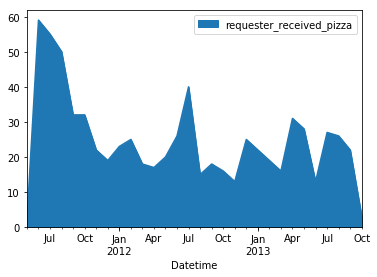

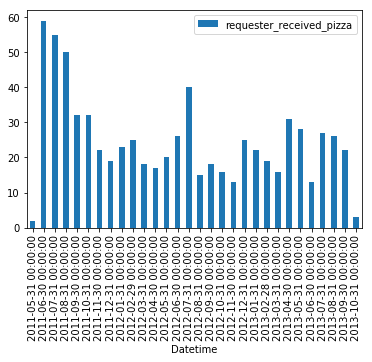

In [14]:
%matplotlib inline

# plot pizzas by month 
month_pizzas = unix_index.resample('M').sum()
month_pizzas_area = month_pizzas.plot(kind='area')
display(month_pizzas_area)


month_pizzas_bar = month_pizzas.plot(kind='bar')
display(month_pizzas_bar)

# Section 2. Simple Feature Selection and Pre-Processing

In [15]:
# Simple Pre-Processing

def data_preprocessor(s):
    """
    Note: this function pre-processors data:
    (1) removes non-alpha characters
    (2) converts digits to 'number'
    (3) regularizes spaces (although CountVectorizer ignores this unless they are part of words)
    (4) reduces word size to n
    """

    s = [re.sub(r'[?|$|.|!|@|\n|(|)|<|>|_|-|,|\']',r' ',s) for s in s] # strip out non-alpha numeric char, replace with space
    s = [re.sub(r'\d+',r'number ',s) for s in s] # convert digits to number
    s = [re.sub(r' +',r' ',s) for s in s] # convert multiple spaces to single space
    
    # This sets word size to n=5
    num = 5
    def set_word(s):
        temp = []
        for s in s:
            x = s.split()
            z = [elem[:num] for elem in x]
            z = ' '.join(z)
            temp.append(z)       
        return temp
    
    s = set_word(s)
    
    return s



In [16]:
# Set up the data with CountVectorizer

#vectorizer = CountVectorizer(lowercase=True, strip_accents='unicode',stop_words='english')

vectorizer = CountVectorizer(min_df=1,lowercase=True)
tVector = vectorizer.fit_transform(trainCorpus)
dVector = vectorizer.transform(devCorpus)

print ('\nRaw data:')
print ("The size of the vocabulary for the training text data is", tVector.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")

tVector_p = vectorizer.fit_transform(data_preprocessor(trainCorpus))
dVector_p = vectorizer.transform(data_preprocessor(devCorpus))

print ('\nPre-Processed data:')
print ("The size of the vocabulary for the training text data is", tVector_p.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")


Raw data:
The size of the vocabulary for the training text data is 17213
First 5 feature Names: ['000', '0000', '0011011001111000', '00243364', '00pm'] 


Pre-Processed data:
The size of the vocabulary for the training text data is 10491
First 5 feature Names: ['aaaaa', 'aan', 'ab', 'aback', 'aband'] 



# Section 3. Baseline Models

## 3.1 Subreddit Models

## Logistic Regression

In [17]:
# Logistic Regression

C = 0.01 #(For now)

modelLogit = LogisticRegression(penalty='l2', C=C)
modelLogit.fit(tVector,trainLabel)
logitScore = round(modelLogit.score(dVector, devLabel), 4)
print("For C = ", C, "Logistic regression accuracy:", logitScore)

modelLogit.fit(tVector_p,trainLabel)
logitScore = round(modelLogit.score(dVector_p, devLabel), 4)
print("For C = ", C, "Logistic regression (processed data) accuracy:", logitScore)


For C =  0.01 Logistic regression accuracy: 0.736
For C =  0.01 Logistic regression (processed data) accuracy: 0.73


## Naive Bayes

In [19]:
# Multinomial NB

alpha = 0.01

clf = BernoulliNB(alpha=alpha)
clf.fit(tVector, trainLabel)
test_predicted_labels = clf.predict(dVector) 
print ('Bernoulli NB using raw data with alpha = %1.3f:' %alpha, metrics.accuracy_score(devLabel,test_predicted_labels) )

clf.fit(tVector_p, trainLabel)
test_predicted_labels = clf.predict(dVector_p) 
print ('Bernoulli NB using processed data  with alpha = %1.3f:' %alpha, metrics.accuracy_score(devLabel,test_predicted_labels) )


Bernoulli NB using raw data with alpha = 0.010: 0.719
Bernoulli NB using processed data  with alpha = 0.010: 0.708


## Logistic Regression More Feature Selection

In [20]:
# get the best regularization
regStrength = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 6.0, 10.0]


for c in regStrength:
    modelLogit = LogisticRegression(penalty='l1', C=c)
    modelLogit.fit(tVector_p, trainLabel)
    logitScore = round(modelLogit.score(dVector_p, devLabel), 4)
    print("For C = ", c, "Logistic regression accuracy:", logitScore)

# although the best score comes from c=.001, the bet F1-score 
# comes from c=.5, and this gives better weight options
modelLogit = LogisticRegression(penalty='l1', C=.5, tol = .1)
modelLogit.fit(tVector_p, trainLabel)

print(max(modelLogit.coef_[0]))
numWeights = 5

sortIndex = np.argsort(modelLogit.coef_)
iLen = len(sortIndex[0])
print("\nTop", numWeights, "Weighted Features:")

for index in range((iLen - numWeights) , iLen):
    lookup = sortIndex[0][index]
    print(lookup)
    weight =  modelLogit.coef_[0][lookup]
    print(vectorizer.get_feature_names()[sortIndex[0][index]], weight)

For C =  0.0001 Logistic regression accuracy: 0.74
For C =  0.001 Logistic regression accuracy: 0.74
For C =  0.01 Logistic regression accuracy: 0.74
For C =  0.1 Logistic regression accuracy: 0.734
For C =  0.5 Logistic regression accuracy: 0.673
For C =  1.0 Logistic regression accuracy: 0.653
For C =  2.0 Logistic regression accuracy: 0.653
For C =  6.0 Logistic regression accuracy: 0.644
For C =  10.0 Logistic regression accuracy: 0.646
1.17829139067

Top 5 Weighted Features:
10070
weds 0.869620169013
4292
hurti 0.911942386507
452
askag 0.928708477471
4411
impre 1.00403630006
10175
wiiu 1.17829139067


## User Status models

In [21]:
# LOGISTIC REGRESSION MODELS
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2')

# create training labels for pizza success
train_labels = np.asarray(allTData['requester_received_pizza'])
dev_labels = np.asarray(allDData['requester_received_pizza'])

# Trial 1: Request / Retrieval 
diff_alone = np.asarray(statusTtrain[['Request', 'Retrieval']].copy())
diff_dev_alone = np.asarray(statusDtrain[['Request', 'Retrieval']].copy())
train_model = lr.fit(diff_alone, train_labels)
dev_alone_labels = train_model.predict(diff_dev_alone)
alone_score = train_model.score(diff_dev_alone, dev_labels)
alone_F1score = metrics.f1_score(dev_alone_labels, dev_labels)
print("For model with Request/Retrieval/Request-Retrieval Difference only")
print("Accuracy:", alone_score)
print("F1 score:", alone_F1score)

# Trial 2:  Z-scores for Request / Retrieval 
zdiff_train = statusTtrain[['Request Z-score','Retrieval Z-score']]
zdiff_dev = statusDtrain[['Request Z-score','Retrieval Z-score']]
zdiff_model = lr.fit(zdiff_train, train_labels)
zdiff_labels = zdiff_model.predict(zdiff_dev)
zdiff_score = zdiff_model.score(zdiff_dev, dev_labels)
zdiff_F1score = metrics.f1_score(zdiff_labels, dev_labels)
print("\nFor model with Request / Retrieval Z-scores only :")
print("Accuracy:", zdiff_score)
print("F1 score:", zdiff_F1score)

# Trial 3:  Z-scores for Request-Retrieval 
# Create Z-scores request-retrieval
diff_combined = np.asarray(statusTtrain[['Request-Retrieval Z-score']].copy())
diff_dev_combined = np.asarray(statusDtrain[['Request-Retrieval Z-score']].copy())
train_combine_model = lr.fit(diff_combined, train_labels)
dev_combine_labels = train_combine_model.predict(diff_dev_combined)
combine_score = train_combine_model.score(diff_dev_combined, dev_labels)
combine_F1score = metrics.f1_score(dev_combine_labels, dev_labels)
print("\nFor model with Request-Retrieval Z-Score only")
print("Accuracy:", combine_score)
print("F1 score:", combine_F1score)

# Trial 4:  Z-scores for Request / Retrieval / Diff / Flair
zcomb_train = statusTtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score', 'requester_user_flair']]
zcomb_train.replace(['None', 'shroom', 'PIF'], [-1, 0, 1])

zcomb_dev = statusDtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score', 'requester_user_flair']]
zcomb_dev.replace(['None', 'shroom', 'PIF'], [-1, 0, 1])

zcomb_model = lr.fit(zcomb_train, train_labels)
zcomb_labels = zcomb_model.predict(zcomb_dev)
zcomb_score = zcomb_model.score(zcomb_dev, dev_labels)
zcomb_F1score = metrics.f1_score(zcomb_labels, dev_labels)
print("\nZ-scores for Request / Retrieval:")
print("Accuracy:", zcomb_score)
print("F1 score:", zcomb_F1score)

For model with Request/Retrieval/Request-Retrieval Difference only
Accuracy: 0.737
F1 score: 0.0

For model with Request / Retrieval Z-scores only :
Accuracy: 0.737
F1 score: 0.0

For model with Request-Retrieval Z-Score only
Accuracy: 0.738
F1 score: 0.0


ValueError: could not convert string to float: 'shroom'

In [ ]:
# LOGISTIC REGRESSION MODELS
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2')

# create training labels for pizza success
train_labels = np.asarray(allTData['requester_number_of_posts_at_request'])
dev_labels = np.asarray(allDData['requester_received_pizza'])

# Trial 1: Request / Retrieval 
diff_alone = np.asarray(statusTtrain[['Request', 'Retrieval']].copy())
diff_dev_alone = np.asarray(statusDtrain[['Request', 'Retrieval']].copy())
train_model = lr.fit(diff_alone, train_labels)
dev_alone_labels = train_model.predict(diff_dev_alone)
alone_score = train_model.score(diff_dev_alone, dev_labels)
alone_F1score = metrics.f1_score(dev_alone_labels, dev_labels)
print("For model with Request/Retrieval/Request-Retrieval Difference only")
print("Accuracy:", alone_score)
print("F1 score:", alone_F1score)

requester_number_of_posts_at_request"


# Vader Sentiment

In [119]:
#Testing our Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
test = "It was one of the worst movies I've seen, despite good reviews."

def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))
    print(snt['compound'])

print_sentiment_scores("It was one of the worst movies I've seen, despite good reviews.")

#sentences = "VADER is smart, handsome, and funny."

#print_sentiment_scores(sentences)

sentences = ["VADER is smart, handsome, and funny.", "VADER is silly, ugly, and rude!"]

for sentence in sentences:
    print("\n")
    print(sentence)
    vs = print_sentiment_scores(sentence)


It was one of the worst movies I've seen, despite good reviews. {'neg': 0.394, 'neu': 0.606, 'pos': 0.0, 'compound': -0.7584}
-0.7584


VADER is smart, handsome, and funny.
VADER is smart, handsome, and funny.---- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
0.8316


VADER is silly, ugly, and rude!
VADER is silly, ugly, and rude!--------- {'neg': 0.617, 'neu': 0.281, 'pos': 0.103, 'compound': -0.7574}
-0.7574


In [120]:
# Setting up for Titles
title = allTData[['request_title', 'requester_received_pizza']].copy()
title.columns = ['Title', 'Got Pizza']
print("\n")
print("Titles and Pizza Success\n")
print(title.head(10))
pizza_title = title.groupby(['Got Pizza'])
print("\n")





Titles and Pizza Success

                                               Title Got Pizza
0  [Request] Just got dumped, no food in the free...     False
1  [Request]  Saint Augustine, US.  Boyfriend and...     False
2        [Request] I'd love a Buffalo Chicken Puzza!      True
3  [REQUEST]- I start class next week and i am st...     False
4        [Request] Pizza for finals in Northern Iowa      True
5      [request]lovepark,il. Preggers and very sad..     False
6  [Request] My friend is letting me stay with hi...     False
7  [Request] Painting our apartment today, would ...     False
8  [REQUEST] Pennsylvania, USA living off PB&amp;...     False
9          [Request] UK - Broke Student Exam Special      True




In [154]:
titles = allTData['request_title']

for title in titles:
    print("\n")
    print_sentiment_scores(title)
    



[Request] Just got dumped, no food in the freezer. Pizza? {'neg': 0.38, 'neu': 0.62, 'pos': 0.0, 'compound': -0.5994}
-0.5994


[Request]  Saint Augustine, US.  Boyfriend and I have no money till next week, and are awaiting food stamps approval. {'neg': 0.103, 'neu': 0.751, 'pos': 0.146, 'compound': 0.2263}
0.2263


[Request] I'd love a Buffalo Chicken Puzza! {'neg': 0.0, 'neu': 0.527, 'pos': 0.473, 'compound': 0.6696}
0.6696


[REQUEST]- I start class next week and i am still with my family. I want to surprise my parents and my brother with an egift card to get pizza before i leave.  {'neg': 0.041, 'neu': 0.845, 'pos': 0.115, 'compound': 0.296}
0.296


[Request] Pizza for finals in Northern Iowa {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
0.0


[request]lovepark,il. Preggers and very sad.. {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
0.0


[Request] My friend is letting me stay with him for a few days after I got out of the hospital, and I know that's a strain. I'

In [158]:
# I think I have the wrong approach here
from sklearn.linear_model import LogisticRegression

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)
    
C = 100

modelLogit = LogisticRegression(penalty = 'l2', C = C)

trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

snt = analyser.polarity_scores(sentence)

title = snt['compound']

modelLogit.fit(tVector,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector),'Logistic Regression, C = 0.001')

modelLogit.fit(got_pizza,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression, C = 0.001')


Logistic Regression, C = 0.001
---------------------------------------------------------------------------
Accuracy:  0.662
Area under curve of ROC:  0.533367983368
Classification report:

             precision    recall  f1-score   support

      False       0.76      0.80      0.78       740
       True       0.32      0.27      0.29       260

avg / total       0.64      0.66      0.65      1000

---------------------------------------------------------------------------


ValueError: X has 10491 features per sample; expecting 1

In [155]:
# Setting up for Body Copy
title = allTData[['request_text', 'requester_received_pizza']].copy()
title.columns = ['Text', 'Got Pizza']
print("\n")
print("Text and Pizza Success\n")
print(title.head(10))
pizza_title = title.groupby(['Got Pizza'])
print("\n")



Text and Pizza Success

                                                Text Got Pizza
0  So it's been a while since it's happened, but ...     False
1  My boyfriend and I live in Saint Augustine, Fl...     False
2  I seriously love buffalo chicken pizza. Like, ...      True
3  I live in philly and a nice egift card would m...     False
4  My friend and I will be studying for finals fo...      True
5  well I am 8 weeks preggers...my name is Sarah....     False
6  RAOP-- you guys are wonderful.\n\nRequest fulf...     False
7  Hey RAOP, we have to white out the walls in ou...     False
8  guys, I have been living off of pbj for 2 days...     False
9  Just paid my rent and now have a scarily small...      True




In [156]:
text = allTData['request_text']

for copy in text:
    print("\n")
    print_sentiment_scores(copy)
    



So it's been a while since it's happened, but yeah. Just got dumped by a girl I like... My brother has used up pretty much everything in the freezer. I would really appreciate a pizza right now... {'neg': 0.083, 'neu': 0.657, 'pos': 0.26, 'compound': 0.8196}
0.8196


My boyfriend and I live in Saint Augustine, Florida and have been having a rough time financially the past few months.  In and out of various jobs, we've had to survive off of coscto sized ramen packs, and pasta and olive oil.  I applied for food stamps a couple days ago, and am waiting to hear back from them.  It's getting a little trite, and we're quite hungry tonight, a hot pizza would be a delight.  We'll happily pay it forward in the future.  Much love. {'neg': 0.033, 'neu': 0.835, 'pos': 0.132, 'compound': 0.8955}
0.8955


I seriously love buffalo chicken pizza. Like, straight up addicted. There's a local pizzeria that delivers and they make the best buffalo chicken pizza I've ever had; however if you dont feel saf

In [159]:
# I think I have the wrong approach here
from sklearn.linear_model import LogisticRegression

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)
    
C = 100

modelLogit = LogisticRegression(penalty = 'l2', C = C)

trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

snt = analyser.polarity_scores(sentence)

title = snt['compound']

modelLogit.fit(tVector,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector),'Logistic Regression, C = 0.001')

modelLogit.fit(got_pizza,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression, C = 0.001')


Logistic Regression, C = 0.001
---------------------------------------------------------------------------
Accuracy:  0.662
Area under curve of ROC:  0.533367983368
Classification report:

             precision    recall  f1-score   support

      False       0.76      0.80      0.78       740
       True       0.32      0.27      0.29       260

avg / total       0.64      0.66      0.65      1000

---------------------------------------------------------------------------


ValueError: X has 10491 features per sample; expecting 1

# Future Steps

* More data pre-processing (looking for newer features too)
* Explore PCA/LSA
* Ideas on features
    - Combination of words
    - Pruning
    - Timing (of requests)
    - Location
    